# Uber Pick-Ups Clustering in NYC

### But du projet : construire des modèles de ML non supervisés afin de déterminer les "zones chaudes" à fort potentiel pour que les chauffeurs UBER se trouvent au bon endroit au bon moment en fonction des moments de la journée pour maximiser le profit de leur tournée

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import  silhouette_score

### Import Data

In [2]:
df_apr14 = pd.read_csv('uber-raw-data-apr14.csv')
df_may14 = pd.read_csv('uber-raw-data-may14.csv')
df_jun14 = pd.read_csv('uber-raw-data-jun14.csv')
df_jul14 = pd.read_csv('uber-raw-data-jul14.csv')
df_aug14 = pd.read_csv('uber-raw-data-aug14.csv')
df_sep14 = pd.read_csv('uber-raw-data-sep14.csv')

frames = [df_apr14, df_may14, df_jun14, df_jul14, df_aug14, df_sep14]
df14 = pd.concat(frames, ignore_index=True)
df14.head()

Date/Time      Lat      Lon    Base
0  4/1/2014 0:11:00  40.7690 -73.9549  B02512
1  4/1/2014 0:17:00  40.7267 -74.0345  B02512
2  4/1/2014 0:21:00  40.7316 -73.9873  B02512
3  4/1/2014 0:28:00  40.7588 -73.9776  B02512
4  4/1/2014 0:33:00  40.7594 -73.9722  B02512

In [3]:
df14.shape

(4534327, 4)

In [4]:
df14.describe(include='all')

Date/Time           Lat           Lon     Base
count             4534327  4.534327e+06  4.534327e+06  4534327
unique             260093           NaN           NaN        5
top     4/7/2014 20:21:00           NaN           NaN   B02617
freq                   97           NaN           NaN  1458853
mean                  NaN  4.073926e+01 -7.397302e+01      NaN
std                   NaN  3.994991e-02  5.726670e-02      NaN
min                   NaN  3.965690e+01 -7.492900e+01      NaN
25%                   NaN  4.072110e+01 -7.399650e+01      NaN
50%                   NaN  4.074220e+01 -7.398340e+01      NaN
75%                   NaN  4.076100e+01 -7.396530e+01      NaN
max                   NaN  4.211660e+01 -7.206660e+01      NaN

In [5]:
df14.isnull().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64

In [6]:
df14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534327 entries, 0 to 4534326
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date/Time  object 
 1   Lat        float64
 2   Lon        float64
 3   Base       object 
dtypes: float64(2), object(2)
memory usage: 138.4+ MB


Aucune missing valuees, en revanche la colonne Date/Time est de type String, on va donc devoir extraires les différents éléments de cette colonne

# Data Cleaning

In [7]:
df14['Date/Time'] = pd.to_datetime(df14['Date/Time'])
df14['year'] = df14['Date/Time'].dt.year
df14['month'] = df14['Date/Time'].dt.month
df14['day'] = df14['Date/Time'].dt.day
df14['day_of_week'] = df14['Date/Time'].dt.day_name()
df14['hour'] = df14['Date/Time'].dt.hour
df14['minute'] = df14['Date/Time'].dt.minute


display(df14.head())
print(df14.dtypes)

Date/Time      Lat      Lon    Base  year  month  day day_of_week  \
0 2014-04-01 00:11:00  40.7690 -73.9549  B02512  2014      4    1     Tuesday   
1 2014-04-01 00:17:00  40.7267 -74.0345  B02512  2014      4    1     Tuesday   
2 2014-04-01 00:21:00  40.7316 -73.9873  B02512  2014      4    1     Tuesday   
3 2014-04-01 00:28:00  40.7588 -73.9776  B02512  2014      4    1     Tuesday   
4 2014-04-01 00:33:00  40.7594 -73.9722  B02512  2014      4    1     Tuesday   

   hour  minute  
0     0      11  
1     0      17  
2     0      21  
3     0      28  
4     0      33

Date/Time      datetime64[ns]
Lat                   float64
Lon                   float64
Base                   object
year                    int32
month                   int32
day                     int32
day_of_week            object
hour                    int32
minute                  int32
dtype: object


# EDA

Nous avons un dataframe qui contient plus de 4M de lignes
Regardons un échantillons des courses uber que l'on va mettre sur une map

In [8]:
data_sample = df14.sample(int(len(df14)*0.005)) # sample 0.5% of data
fig = px.scatter_mapbox(data_sample, lat='Lat', lon='Lon')
fig.update_layout(mapbox_style="open-street-map", width=600, height=300,
                  margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [9]:
data_day_hour = (df14.groupby(['day_of_week', 'hour'])
                    .size()
                    .reset_index(name='count'))

# Ordonner les jours
jour_ordre = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data_day_hour['day_of_week'] = pd.Categorical(data_day_hour['day_of_week'], 
                                             categories=jour_ordre, 
                                             ordered=True)

fig = px.line(
    data_day_hour, 
    x='hour', 
    y='count', 
    color='day_of_week',
    facet_col='day_of_week',
    title="Évolution par jour de la semaine et heure"
)

fig.update_layout(
    showlegend=False,
    xaxis=dict(tickvals=list(range(0, 25, 6))),
    height=600
)




Cette visualisation nous permet de voir pour les mois de l'année 2014 l'enemble de l'activité cumulé des chauffeurs uber en fonction des jours de la semaine. Contrairement à ce que l'on pourrait penser, ce n'est pas le samedi où il y a le plus d'activité. Ce qui est finalement normal car aux USA, la semaine commence le dimanche

In [10]:
df14.head()

Date/Time      Lat      Lon    Base  year  month  day day_of_week  \
0 2014-04-01 00:11:00  40.7690 -73.9549  B02512  2014      4    1     Tuesday   
1 2014-04-01 00:17:00  40.7267 -74.0345  B02512  2014      4    1     Tuesday   
2 2014-04-01 00:21:00  40.7316 -73.9873  B02512  2014      4    1     Tuesday   
3 2014-04-01 00:28:00  40.7588 -73.9776  B02512  2014      4    1     Tuesday   
4 2014-04-01 00:33:00  40.7594 -73.9722  B02512  2014      4    1     Tuesday   

   hour  minute  
0     0      11  
1     0      17  
2     0      21  
3     0      28  
4     0      33

# Clustering sur 1 jours et une heure spécifique

On va regarder sur le vendredi à 17h, puisque d'après notre EDA c'est le jour et l'heure où il y a le plus gros pique d'activité

In [11]:
data_day_hour_selected = df14[(df14['day_of_week'] == 'Thursday') & (df14['hour'] == 17)].drop(columns='Date/Time', axis=1)
print(data_day_hour_selected.shape)
data_day_hour_selected

(56704, 9)


Lat      Lon    Base  year  month  day day_of_week  hour  minute
3119     40.7675 -73.9666  B02512  2014      4    3    Thursday    17       0
3120     40.7688 -73.8624  B02512  2014      4    3    Thursday    17       0
3121     40.7356 -74.0079  B02512  2014      4    3    Thursday    17       1
3122     40.6816 -73.9255  B02512  2014      4    3    Thursday    17       2
3123     40.7677 -73.9826  B02512  2014      4    3    Thursday    17       2
...          ...      ...     ...   ...    ...  ...         ...   ...     ...
4492503  40.6774 -73.9764  B02764  2014      9   25    Thursday    17      59
4492504  40.7141 -74.0029  B02764  2014      9   25    Thursday    17      59
4492505  40.7511 -73.9824  B02764  2014      9   25    Thursday    17      59
4492506  40.7012 -73.9428  B02764  2014      9   25    Thursday    17      59
4492507  40.7012 -73.9428  B02764  2014      9   25    Thursday    17      59

[56704 rows x 9 columns]

In [12]:
numeric_features_no_change = [0, 1]
numeric_transformer_no_change = Pipeline(steps=[
   ('passthrough', FunctionTransformer(lambda x: x))
])

#Here we only needed one preprocessing, that doesn't change the geo num values
#The values due to dates and time are not needed in the model
#The Base code creates to much categorical column in preprocessing to handle it with clustering model

preprocessor = ColumnTransformer(
    transformers=[
        ('num_no_change', numeric_transformer_no_change, numeric_features_no_change), # on fait passer que Lat et Lon dans le preprocessor, sans même y toucher 
    ])

# Preprocessings on dataset
print("Preprocessing sur le train set...")
print(data_day_hour_selected.head())
X = preprocessor.fit_transform(data_day_hour_selected) # fit_transform !!
print('...Terminé.')
print(X[0:5, :])
print()

Preprocessing sur le train set...
          Lat      Lon    Base  year  month  day day_of_week  hour  minute
3119  40.7675 -73.9666  B02512  2014      4    3    Thursday    17       0
3120  40.7688 -73.8624  B02512  2014      4    3    Thursday    17       0
3121  40.7356 -74.0079  B02512  2014      4    3    Thursday    17       1
3122  40.6816 -73.9255  B02512  2014      4    3    Thursday    17       2
3123  40.7677 -73.9826  B02512  2014      4    3    Thursday    17       2
...Terminé.
[[ 40.7675 -73.9666]
 [ 40.7688 -73.8624]
 [ 40.7356 -74.0079]
 [ 40.6816 -73.9255]
 [ 40.7677 -73.9826]]



### KMeans

In [13]:
wcss =  []
sil = []
for i in range (2,11):
    kmeans = KMeans(n_clusters= i)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    sil.append(silhouette_score(X, kmeans.predict(X)))

print(wcss)
print(sil)

[126.03988355519027, 102.28883890648503, 78.5189605380176, 60.02236361023907, 60.15974703216944, 42.75362816524799, 39.91498882507045, 31.418500898341957, 28.877470431572412]
[0.7456770791972184, 0.39278802776795274, 0.4569551945031251, 0.4631454480571041, 0.4622757160704486, 0.46490338497981676, 0.46763144490192254, 0.3986724842111989, 0.4536223577918947]


In [14]:
fig = px.line(x = range(2,11), y = wcss, height=600, width=800)
fig.show()

In [15]:
fig = px.bar(x = range(2,11), y = sil, height=600, width=800)
fig.show()

D'après notre Elbow, on pourrait prendre un nombre k qui se situe entre 2 et 5 car le plateau intervient à partir de la valeur 5. Or, si on regarde Silhouette, on voit que à la valeur 3, on est pas très élevé donc on élimine. Pour la valeur 2, on est élevé mais 2 clusters n'est pas représentatif. On va donc prendre n_cluster = 5 pour avoir un bon équilibre entre un score de silhouette à 0.75 ce qui est excellent, une réalité géographique et un bon compromis complexité/performance.

Pour rappel, la cassure sur le Elbow indique que : 
- avant le coude, chaque cluster apporte/veut dire beaucoup
- après le coude, chaque cluster ajouté apporte peu

Silhouette = (b-a)/max(a,b) avec:
- a = distance moyenne aux points du même cluster
- b= distance moyenne aux points du cluster le plus proche

Donc un silhouette à 0.75 est excellent et donne des clusters très disctincts et significatifs

In [19]:
kmeans = KMeans(n_clusters= 5)
kmeans.fit(X)

KMeans(n_clusters=5)

In [20]:
# on rajoute une colonne dans notre dataframe des clusters identifiés par KMeans
data_day_hour_selected.loc[:,'Cluster_KMeans'] = kmeans.predict(X)
data_day_hour_selected.head()

Lat      Lon    Base  year  month  day day_of_week  hour  minute  \
3119  40.7675 -73.9666  B02512  2014      4    3    Thursday    17       0   
3120  40.7688 -73.8624  B02512  2014      4    3    Thursday    17       0   
3121  40.7356 -74.0079  B02512  2014      4    3    Thursday    17       1   
3122  40.6816 -73.9255  B02512  2014      4    3    Thursday    17       2   
3123  40.7677 -73.9826  B02512  2014      4    3    Thursday    17       2   

      Cluster_KMeans  
3119               0  
3120               2  
3121               3  
3122               3  
3123               0

In [21]:
px.scatter_mapbox(
    data_day_hour_selected,
    lat="Lat",
    lon="Lon",
    color="Cluster_KMeans",
    mapbox_style="carto-positron",
    zoom=10,
    height=600,
    width=800
)

# DBScan

On va identifier le "coude" pour savoir quel epsilon choisir. On utilise la méthode des plus proches voisins qui permettra de trouver les 2 plus proches voisins pour chaque points

In [22]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
px.line(distances, height=600, width=800)

Comment interpréter ce graphique ? 
- Axe X, ce sont les index des points triés par distance croissante (de 0 à 55k points)
- Axe Y, c'est la distance au 2ème plus proche voisin pour chaque point
On remarque une zone plate entre 0 et 53k à peu près, la distance entre les points est très proche de 0 voir de 0 donc ces points appartiennent à des clusters denses
Entre 52k et 55k on voit un coude se former et des valeurs de y augmenter. Ce sont des points suspects, potentiellement outliers et les plus proches voisins deviennent de plus en plus lointains. Du coup on va choisir un sueil à ne pas dépasser puisqu'une fois dépasser ce sont des outliers. Du coup notre epsilon se situe entre 0.001 et maximum 0.025.

In [28]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin = []
sil = []

# metric euclidean car on travaille sur des coordonnées géographiques, manhattan pertinent si on analysait les temps de trajets
#Boucle qui teste 19 valeurs d'epsilon avec 0.025 exclu
for i in np.arange(0.001, 0.025, 0.001):  # Focus sur la zone pertinente ave en paramètre start, stop, step
    db = DBSCAN(eps=i, min_samples=4, metric="euclidean") #min_sample = 4 car on entraine sur deux dimensions (Lat, Lon) et généralement on prend 2*dim
    db.fit(X)
    
    # Vérifier qu'on a au moins 2 clusters (sinon silhouette échoue)
    if len(set(db.labels_)) > 1: #on vérifie qu'il y a plus d'un cluster
        davies_bouldin.append(davies_bouldin_score(X, db.labels_))
        sil.append(silhouette_score(X, db.labels_))
    else:
        davies_bouldin.append(np.inf)  # Mauvais score si un seul cluster
        sil.append(-1)  # Mauvais score si un seul cluster

print("Davies-Bouldin:", davies_bouldin)
print("Silhouette:", sil)

Davies-Bouldin: [2.4321479902274787, 3.03422704710715, 4.038831220480052, 2.3173833678609257, 2.250542750302243, 2.369079608265403, 2.444876869475301, 2.3318434920541766, 2.6283959773971657, 2.3882894649966957, 2.026358445825912, 1.9297105836967186, 1.98014748928942, 1.958325102965175, 2.0171866355184496, 2.0633370486204345, 1.9239652594435284, 1.933211324691088, 2.0220658312709916, 2.0741467335340773, 2.044905669951084, 2.0368215363765305, 2.14555088163467, 2.020241137580724]
Silhouette: [-0.315447920572467, -0.00011816490459671229, 0.047645689277426795, 0.250501306899363, 0.11610252403100518, 0.07835750109520426, 0.07639306896080598, 0.23186373121316967, 0.2744958335172386, 0.21809754262913789, 0.22789447786631392, 0.31276639224612185, 0.25303742321312866, 0.41817787825755526, 0.4184113782685607, 0.4186868733045114, 0.42652555199069603, 0.44583902231204436, 0.4461684208506676, 0.44468614338794044, 0.45050411945401925, 0.44774739956930376, 0.44271655183560094, 0.6384595986023651]


Regardons les graphiques de Davies Bouldin et Silhouette
Plus DB est bas, mieux c'est pour choisir notre eps, et plus silhouette est haut, mieux c'est

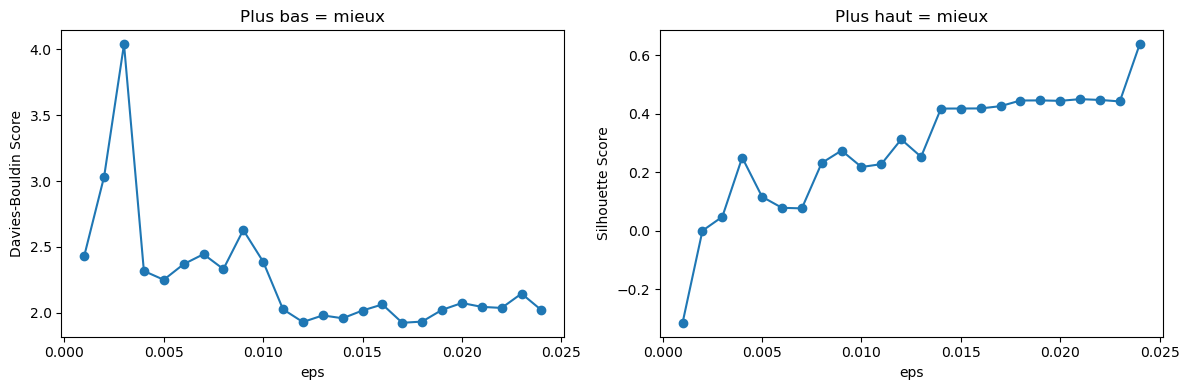

In [29]:
import matplotlib.pyplot as plt

eps_values = np.arange(0.001, 0.025, 0.001)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(eps_values, davies_bouldin, 'o-')
ax1.set_xlabel('eps')
ax1.set_ylabel('Davies-Bouldin Score')
ax1.set_title('Plus bas = mieux')

ax2.plot(eps_values, sil, 'o-')
ax2.set_xlabel('eps') 
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Plus haut = mieux')

plt.tight_layout()


On va prendre un eps = 0.024 suite aux résultats

In [30]:
db = DBSCAN(eps=0.024, min_samples=4, metric="euclidean")
# Due to the 2 previous graphs, we choose eps = 0.05 to have a best silouhette score and davies bouldin score
# min_sample = 4 because it is better to choose (2*nb of features) here lat and lon
db.fit(X)

DBSCAN(eps=0.024, min_samples=4)

In [31]:
data_day_hour_selected.loc[:,'Cluster_DBSCAN'] = db.labels_
data_day_hour_selected.head()

Lat      Lon    Base  year  month  day day_of_week  hour  minute  \
3119  40.7675 -73.9666  B02512  2014      4    3    Thursday    17       0   
3120  40.7688 -73.8624  B02512  2014      4    3    Thursday    17       0   
3121  40.7356 -74.0079  B02512  2014      4    3    Thursday    17       1   
3122  40.6816 -73.9255  B02512  2014      4    3    Thursday    17       2   
3123  40.7677 -73.9826  B02512  2014      4    3    Thursday    17       2   

      Cluster_KMeans  Cluster_DBSCAN  
3119               0               0  
3120               2               0  
3121               3               0  
3122               3               0  
3123               0               0

In [32]:
px.scatter_mapbox(
    data_day_hour_selected[data_day_hour_selected.Cluster_DBSCAN != -1],
    lat="Lat",
    lon="Lon",
    color="Cluster_DBSCAN",
    mapbox_style="carto-positron",
    zoom=9,
    height=600,
    width=800
)

# Généralisons sur les jours de la semaine

In [46]:
df14.head()

Date/Time      Lat      Lon    Base  year  month  day day_of_week  \
0 2014-04-01 00:11:00  40.7690 -73.9549  B02512  2014      4    1     Tuesday   
1 2014-04-01 00:17:00  40.7267 -74.0345  B02512  2014      4    1     Tuesday   
2 2014-04-01 00:21:00  40.7316 -73.9873  B02512  2014      4    1     Tuesday   
3 2014-04-01 00:28:00  40.7588 -73.9776  B02512  2014      4    1     Tuesday   
4 2014-04-01 00:33:00  40.7594 -73.9722  B02512  2014      4    1     Tuesday   

   hour  minute  
0     0      11  
1     0      17  
2     0      21  
3     0      28  
4     0      33

In [47]:
df14.drop(columns='Date/Time', inplace=True)  # Drop the Date/Time column as it is not needed for clustering

In [48]:
# création d'un dictionnaire pour stocker les dataframes correspondant à chaque jour de la semaine
dict_df_per_day = {}

for day in df14["day_of_week"].unique():
    dict_df_per_day[f"df14_day_{day}"] = df14[(df14["day_of_week"] == day)]



In [49]:
dict_df_per_day.keys()

dict_keys(['df14_day_Tuesday', 'df14_day_Wednesday', 'df14_day_Thursday', 'df14_day_Friday', 'df14_day_Saturday', 'df14_day_Sunday', 'df14_day_Monday'])

In [50]:
# Mapping des jours pour correspondre aux valeurs de df14
day_mapping = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
}

# Création directe du dictionnaire
dict_df_per_day = {
    f"df14_day_{day_mapping[day]}": df14[df14["day_of_week"] == day]
    for day in df14["day_of_week"].unique()
}
dict_df_per_day.keys()

dict_keys(['df14_day_1', 'df14_day_2', 'df14_day_3', 'df14_day_4', 'df14_day_5', 'df14_day_6', 'df14_day_0'])

In [51]:
numeric_features_no_change = [0, 1]
numeric_transformer_no_change = Pipeline(steps=[
   ('passthrough', FunctionTransformer(lambda x: x))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num_no_change', numeric_transformer_no_change, numeric_features_no_change),
    ])


X_dict = {}

for i in range(0, 7):
    # Preprocessings sur le dataset
    print(f"Preprocessing pour le day_of_week {i}...")
    print(dict_df_per_day[f"df14_day_{i}"].head())
    X_dict[f"X_{i}"] = preprocessor.fit_transform(dict_df_per_day[f"df14_day_{i}"]) # fit_transform !!
    print('...Terminé.')

Preprocessing pour le day_of_week 0...
          Lat      Lon    Base  year  month  day day_of_week  hour  minute
7785  40.7205 -73.9939  B02512  2014      4    7      Monday     0      31
7786  40.7407 -74.0077  B02512  2014      4    7      Monday     0      37
7787  40.7591 -73.9892  B02512  2014      4    7      Monday     0      50
7788  40.7419 -74.0034  B02512  2014      4    7      Monday     0      58
7789  40.7419 -74.0034  B02512  2014      4    7      Monday     1      27
...Terminé.
Preprocessing pour le day_of_week 1...
       Lat      Lon    Base  year  month  day day_of_week  hour  minute
0  40.7690 -73.9549  B02512  2014      4    1     Tuesday     0      11
1  40.7267 -74.0345  B02512  2014      4    1     Tuesday     0      17
2  40.7316 -73.9873  B02512  2014      4    1     Tuesday     0      21
3  40.7588 -73.9776  B02512  2014      4    1     Tuesday     0      28
4  40.7594 -73.9722  B02512  2014      4    1     Tuesday     0      33
...Terminé.
Preprocessing po

### KMeans

In [52]:
for i in range(7):

    kmeans = KMeans(n_clusters= 5)
    kmeans.fit(X_dict[f"X_{i}"])

    dict_df_per_day[f"df14_day_{i}"].loc[:,'Cluster_KMeans'] = kmeans.predict(X_dict[f"X_{i}"])
    display(dict_df_per_day[f"df14_day_{i}"].head())

C:\Users\kleim\AppData\Local\Temp\ipykernel_11696\3422456001.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Lat      Lon    Base  year  month  day day_of_week  hour  minute  \
7785  40.7205 -73.9939  B02512  2014      4    7      Monday     0      31   
7786  40.7407 -74.0077  B02512  2014      4    7      Monday     0      37   
7787  40.7591 -73.9892  B02512  2014      4    7      Monday     0      50   
7788  40.7419 -74.0034  B02512  2014      4    7      Monday     0      58   
7789  40.7419 -74.0034  B02512  2014      4    7      Monday     1      27   

      Cluster_KMeans  
7785               2  
7786               2  
7787               0  
7788               2  
7789               2

C:\Users\kleim\AppData\Local\Temp\ipykernel_11696\3422456001.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Lat      Lon    Base  year  month  day day_of_week  hour  minute  \
0  40.7690 -73.9549  B02512  2014      4    1     Tuesday     0      11   
1  40.7267 -74.0345  B02512  2014      4    1     Tuesday     0      17   
2  40.7316 -73.9873  B02512  2014      4    1     Tuesday     0      21   
3  40.7588 -73.9776  B02512  2014      4    1     Tuesday     0      28   
4  40.7594 -73.9722  B02512  2014      4    1     Tuesday     0      33   

   Cluster_KMeans  
0               0  
1               1  
2               1  
3               0  
4               0

C:\Users\kleim\AppData\Local\Temp\ipykernel_11696\3422456001.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Lat      Lon    Base  year  month  day day_of_week  hour  minute  \
1011  40.7458 -73.9843  B02512  2014      4    2   Wednesday     0       0   
1012  40.7285 -74.0467  B02512  2014      4    2   Wednesday     0       5   
1013  40.7732 -73.9546  B02512  2014      4    2   Wednesday     0       7   
1014  40.6550 -73.9786  B02512  2014      4    2   Wednesday     0      11   
1015  40.7405 -74.0040  B02512  2014      4    2   Wednesday     0      21   

      Cluster_KMeans  
1011               2  
1012               2  
1013               0  
1014               4  
1015               2

C:\Users\kleim\AppData\Local\Temp\ipykernel_11696\3422456001.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Lat      Lon    Base  year  month  day day_of_week  hour  minute  \
2347  40.7422 -74.0062  B02512  2014      4    3    Thursday     0       0   
2348  40.7239 -74.0034  B02512  2014      4    3    Thursday     0       2   
2349  40.7239 -74.0034  B02512  2014      4    3    Thursday     0       2   
2350  40.7104 -74.0118  B02512  2014      4    3    Thursday     0       2   
2351  40.7221 -73.9837  B02512  2014      4    3    Thursday     0      10   

      Cluster_KMeans  
2347               2  
2348               2  
2349               2  
2350               2  
2351               2

C:\Users\kleim\AppData\Local\Temp\ipykernel_11696\3422456001.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Lat      Lon    Base  year  month  day day_of_week  hour  minute  \
3829  40.7528 -73.9858  B02512  2014      4    4      Friday     0       3   
3830  40.7263 -74.0018  B02512  2014      4    4      Friday     0       5   
3831  40.7263 -73.9917  B02512  2014      4    4      Friday     0      12   
3832  40.7813 -73.9516  B02512  2014      4    4      Friday     0      12   
3833  40.7170 -73.9987  B02512  2014      4    4      Friday     0      14   

      Cluster_KMeans  
3829               0  
3830               3  
3831               3  
3832               0  
3833               3

C:\Users\kleim\AppData\Local\Temp\ipykernel_11696\3422456001.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Lat      Lon    Base  year  month  day day_of_week  hour  minute  \
5656  40.7690 -73.9825  B02512  2014      4    5    Saturday     0       0   
5657  40.7594 -73.9641  B02512  2014      4    5    Saturday     0       0   
5658  40.7113 -74.0173  B02512  2014      4    5    Saturday     0       1   
5659  40.8060 -73.9652  B02512  2014      4    5    Saturday     0       2   
5660  40.7211 -74.0042  B02512  2014      4    5    Saturday     0       4   

      Cluster_KMeans  
5656               0  
5657               0  
5658               4  
5659               0  
5660               4

C:\Users\kleim\AppData\Local\Temp\ipykernel_11696\3422456001.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Lat      Lon    Base  year  month  day day_of_week  hour  minute  \
6965  40.6547 -74.3033  B02512  2014      4    6      Sunday     0       0   
6966  40.7356 -74.0006  B02512  2014      4    6      Sunday     0       0   
6967  40.7421 -74.0041  B02512  2014      4    6      Sunday     0       0   
6968  40.7401 -74.0053  B02512  2014      4    6      Sunday     0       0   
6969  40.7368 -73.9877  B02512  2014      4    6      Sunday     0       1   

      Cluster_KMeans  
6965               3  
6966               1  
6967               1  
6968               1  
6969               1

On a nos clusters par jour de la semaine
Plotons les maps pour les différents jours

In [53]:
def plot_map_kmeans(i):
    fig = px.scatter_mapbox(
        dict_df_per_day[f"df14_day_{i}"],
        lat="Lat",
        lon="Lon",
        color="Cluster_KMeans",
        mapbox_style="carto-positron",
        zoom=9,
        height=600,
        width=800,
        title=f"Clustering map of hot-zones for the day_of_week {i}"
    )

    fig.show()